## 1. Imports & Setup

In [106]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)

print("Setup complete")

Setup complete


## 2. Load Datasets

In [107]:
# List of dataset paths
dataset_paths = [
    "../data/orderbook_data/eth_orderbook_preprocessed_with_raw_price.csv",  # Use version with raw prices
     "../data/orderbook_data/eth_orderbook_coinbase_combined_preprocessed.csv",
]

# Load all datasets
dataframes = []
for path in dataset_paths:
    df = pd.read_csv(path, parse_dates=["timestamp"])
    print(f"Loaded {path}: {df.shape}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    # Check if it has raw_midpoint column
    if 'raw_midpoint' in df.columns:
        print(f"  Has raw_midpoint: {df['raw_midpoint'].min():.2f} to {df['raw_midpoint'].max():.2f}")
    else:
        print(f"  Midpoint: {df['midpoint'].min():.2f} to {df['midpoint'].max():.2f}")
    dataframes.append(df)    

print(f"\nTotal datasets: {len(dataframes)}")

Loaded ../data/orderbook_data/eth_orderbook_preprocessed_with_raw_price.csv: (17088, 312)
  Date range: 2021-04-07 11:55:49.861733+00:00 to 2021-04-19 09:53:00.345392+00:00
  Has raw_midpoint: 1937.43 to 2546.41
Loaded ../data/orderbook_data/eth_orderbook_coinbase_combined_preprocessed.csv: (13000, 91)
  Date range: 2025-11-18 01:09:15.259076 to 2025-11-27 03:27:56.101553
  Midpoint: 2627.28 to 3167.40

Total datasets: 2


## 3. Feature Alignment Diagnostic

**Critical Check**: Verify both datasets have consistent feature definitions and distributions.

In [108]:
# Quick diagnostic: compare feature distributions across datasets
print("="*80)
print("FEATURE ALIGNMENT DIAGNOSTIC")
print("="*80)

dataset_names = [
    "2021 Online (eth_orderbook_preprocessed_with_raw_price)",
    "2025 Coinbase (eth_orderbook_coinbase_combined_preprocessed)"
]

# Sample common features for quick check
diagnostic_features = [
    'norm_bids_distance_0', 'norm_asks_distance_0',
    'norm_bids_notional_0', 'norm_asks_notional_0',
    'norm_buys', 'norm_sells',
    'delta_norm_bids_distance_0', 'delta_norm_asks_distance_0',
    'spread', 'spread_bps'
]

for i, (df, name) in enumerate(zip(dataframes, dataset_names)):
    print(f"\n{'-'*80}")
    print(f"Dataset {i}: {name}")
    print(f"{'-'*80}")
    
    # Check which diagnostic features exist
    available_features = [f for f in diagnostic_features if f in df.columns]
    
    if available_features:
        desc = df[available_features].describe().T
        print(f"\n{desc[['mean', 'std', 'min', 'max']]}")
    else:
        print("  WARNING: No diagnostic features found!")
    
    # Check for raw_midpoint (needed for labels)
    if 'raw_midpoint' in df.columns:
        print(f"\n  ✓ Has raw_midpoint: {df['raw_midpoint'].min():.2f} to {df['raw_midpoint'].max():.2f}")
    elif 'midpoint' in df.columns:
        print(f"\n  ⚠ Missing raw_midpoint, using midpoint: {df['midpoint'].min():.2f} to {df['midpoint'].max():.2f}")
    else:
        print(f"\n  ❌ ERROR: No price column found for labels!")

print(f"\n{'='*80}")
print("NOTES:")
print("  - norm_*_distance features should have similar scales (small %, ~0.001-0.01 range)")
print("  - norm_*_notional features are [0,1] by definition (normalized within each timestamp)")
print("  - norm_buys/sells should sum to ~1.0")
print("  - delta_* features measure change, expect mean≈0 with small std")
print("  - If distributions differ wildly, feature engineering may be inconsistent!")
print("="*80)

FEATURE ALIGNMENT DIAGNOSTIC

--------------------------------------------------------------------------------
Dataset 0: 2021 Online (eth_orderbook_preprocessed_with_raw_price)
--------------------------------------------------------------------------------

                                    mean       std        min        max
norm_bids_distance_0        3.451255e-17  1.000029 -54.146820   0.582363
norm_asks_distance_0        2.079069e-17  1.000029  -0.582363  54.146820
norm_bids_notional_0       -8.316277e-18  1.000029  -0.531931  25.112348
norm_asks_notional_0        2.546860e-17  1.000029  -0.490875  37.827584
norm_buys                  -2.079069e-17  1.000029  -0.952599   8.809724
norm_sells                  2.037488e-17  1.000029  -0.736765  10.125626
delta_norm_bids_distance_0  1.428061e-17  1.000029 -40.890347  43.842960
delta_norm_asks_distance_0 -1.316311e-17  1.000029 -43.842960  40.890347
spread                      3.077023e-17  1.000029  -0.595744  47.874421
spread_bps

## 3. Feature Selection

Ensure all datasets have the same features.

In [109]:
# Find common features across all datasets
# Start with features from first dataset
# Include BOTH norm and delta features for temporal signals
# EXCLUDE raw price features (midpoint, ETH_price) - only use normalized/delta features
feature_cols_candidates = [col for col in dataframes[0].columns if (
    col.startswith('norm_bids_distance_') or
    col.startswith('norm_asks_distance_') or
    col.startswith('norm_bids_notional_') or
    col.startswith('norm_asks_notional_') or
    col.startswith('delta_norm_bids_distance_') or
    col.startswith('delta_norm_asks_distance_') or
    col.startswith('delta_norm_bids_notional_') or
    col.startswith('delta_norm_asks_notional_') or
    col in ['norm_buys', 'norm_sells', 'delta_norm_buys', 'delta_norm_sells', 'spread', 'spread_bps']
)]

# Filter to only features that exist in ALL datasets
feature_cols = []
for col in feature_cols_candidates:
    if all(col in df.columns for df in dataframes):
        feature_cols.append(col)

print(f"Selected {len(feature_cols)} common features")
print(f"Sample features: {feature_cols[:5]}")

# Verify all datasets have these features
for i, df in enumerate(dataframes):
    missing = set(feature_cols) - set(df.columns)
    if missing:
        print(f"WARNING: Dataset {i} missing features: {missing}")
    else:
        print(f"Dataset {i}: All features present ✓")

# Show what features were excluded
excluded = set(feature_cols_candidates) - set(feature_cols)
if excluded:
    print(f"\nExcluded features (not in all datasets): {len(excluded)}")
    print(f"  e.g., {list(excluded)[:5]}")

Selected 86 common features
Sample features: ['spread', 'spread_bps', 'norm_bids_distance_0', 'norm_bids_distance_1', 'norm_bids_distance_2']
Dataset 0: All features present ✓
Dataset 1: All features present ✓

Excluded features (not in all datasets): 40
  e.g., ['delta_norm_bids_notional_14', 'norm_asks_distance_12', 'delta_norm_asks_notional_14', 'norm_bids_notional_13', 'delta_norm_bids_distance_11']


## 4. Label Creation Function

In [110]:
def create_directional_labels(prices, horizon=30, threshold=0.05):
    """
    Create 3-class directional labels based on which threshold is hit first.
    
    Args:
        prices: Array of prices (use ETH_price for actual spot price, or midpoint)
        horizon: Number of periods to look ahead
        threshold: Percentage move threshold (e.g., 0.006 = 0.6%)
    
    Returns:
        0 if price drops by threshold% first (bearish)
        1 if price rises by threshold% first (bullish)
        2 if neither threshold is hit within horizon (neutral)
        -1 if insufficient future data (will be filtered out)
    """
    labels = []
    
    for i in tqdm(range(len(prices)), desc="Creating labels"):
        if i + horizon >= len(prices):
            labels.append(-1)  # Mark as invalid (insufficient future data)
            continue
        
        current_price = prices[i]
        future_prices = prices[i+1:i+horizon+1]
        
        # Calculate percentage changes
        pct_changes = (future_prices - current_price) / current_price
        
        # Find first index where upper threshold is breached
        upper_breaches = np.where(pct_changes >= threshold)[0]
        first_upper_idx = upper_breaches[0] if len(upper_breaches) > 0 else np.inf
        
        # Find first index where lower threshold is breached
        lower_breaches = np.where(pct_changes <= -threshold)[0]
        first_lower_idx = lower_breaches[0] if len(lower_breaches) > 0 else np.inf
        
        # 3-CLASS: Keep neutral samples
        if first_upper_idx < first_lower_idx:
            labels.append(1)  # Bullish (UP)
        elif first_lower_idx < first_upper_idx:
            labels.append(0)  # Bearish (DOWN)
        else:
            labels.append(2)  # Neutral (no strong move)
    
    return np.array(labels)

print("3-class label creation function defined")

3-class label creation function defined


## 5. Create Sequences Function

In [111]:
def create_sequences(features, labels, lookback=60):
    """
    Create sliding window sequences.
    """
    X, y = [], []
    
    for i in tqdm(range(lookback, len(features)), desc="Creating sequences"):
        X.append(features[i-lookback:i])
        y.append(labels[i])
    
    return np.array(X), np.array(y)

print("Sequence creation function defined")

Sequence creation function defined


## 6. Process Each Dataset

In [112]:
# Parameters
HORIZON = 60  # 60 minutes
THRESHOLD = 0.006  # 0.6% move
LOOKBACK = 60  # 60-minute lookback for context

# Storage for combined data
all_X = []
all_y = []
all_dataset_id = []  # NEW: Track which dataset each sequence came from

for i, df in enumerate(dataframes):
    print(f"\n{'='*60}")
    print(f"Processing Dataset {i+1}/{len(dataframes)}")
    print(f"{'='*60}")
    
    # Use raw_midpoint if available (actual prices), otherwise use midpoint
    if 'raw_midpoint' in df.columns:
        prices = df['raw_midpoint'].values
        print(f"Using raw_midpoint for labels (actual prices: {prices.min():.2f} to {prices.max():.2f})")
    else:
        prices = df['midpoint'].values
        print(f"Using midpoint for labels (actual prices: {prices.min():.2f} to {prices.max():.2f})")
    
    labels = create_directional_labels(prices, horizon=HORIZON, threshold=THRESHOLD)
    
    # Filter out invalid labels (insufficient future data only)
    valid_mask = np.array(labels) != -1
    labels_array = np.array(labels)[valid_mask]
    
    print(f"\nLabels created: {len(labels_array)} valid (removed {np.sum(~valid_mask)} with insufficient future data)")
    print(f"3-class distribution: {np.bincount(labels_array)}")
    print(f"  0=Bearish: {np.sum(labels_array == 0)} ({100*np.sum(labels_array == 0)/len(labels_array):.1f}%)")
    print(f"  1=Bullish: {np.sum(labels_array == 1)} ({100*np.sum(labels_array == 1)/len(labels_array):.1f}%)")
    print(f"  2=Neutral: {np.sum(labels_array == 2)} ({100*np.sum(labels_array == 2)/len(labels_array):.1f}%)")
    
    # Extract features (only for valid labels)
    X_features = df[feature_cols].values[valid_mask]
    
    # Create sequences (no scaling yet - will scale after combining)
    X_seq, y_seq = create_sequences(X_features, labels_array, lookback=LOOKBACK)
    
    print(f"\nSequences created: {X_seq.shape}")
    
    # Store sequences and dataset ID
    all_X.append(X_seq)
    all_y.append(y_seq)
    all_dataset_id.append(np.full(len(y_seq), i, dtype=np.int32))  # Track dataset origin
    
    print(f"Dataset ID: {i} assigned to {len(y_seq)} sequences")

print(f"\n{'='*60}")
print("All datasets processed!")
print(f"{'='*60}")


Processing Dataset 1/2
Using raw_midpoint for labels (actual prices: 1937.43 to 2546.41)


Creating labels: 100%|██████████| 17088/17088 [00:00<00:00, 242201.50it/s]



Labels created: 17028 valid (removed 60 with insufficient future data)
3-class distribution: [5875 5843 5310]
  0=Bearish: 5875 (34.5%)
  1=Bullish: 5843 (34.3%)
  2=Neutral: 5310 (31.2%)


Creating sequences: 100%|██████████| 16968/16968 [00:00<00:00, 3637378.63it/s]




Sequences created: (16968, 60, 86)
Dataset ID: 0 assigned to 16968 sequences

Processing Dataset 2/2
Using midpoint for labels (actual prices: 2627.28 to 3167.40)


Creating labels: 100%|██████████| 13000/13000 [00:00<00:00, 231700.95it/s]



Labels created: 12940 valid (removed 60 with insufficient future data)
3-class distribution: [4593 4192 4155]
  0=Bearish: 4593 (35.5%)
  1=Bullish: 4192 (32.4%)
  2=Neutral: 4155 (32.1%)


Creating sequences: 100%|██████████| 12880/12880 [00:00<00:00, 3657096.91it/s]




Sequences created: (12880, 60, 86)
Dataset ID: 1 assigned to 12880 sequences

All datasets processed!


## 7. Combine Datasets

In [113]:
# Concatenate all sequences
X_combined = np.concatenate(all_X, axis=0)
y_combined = np.concatenate(all_y, axis=0)
dataset_id_combined = np.concatenate(all_dataset_id, axis=0)  # NEW: Combined dataset IDs

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")
print(f"Combined dataset_id shape: {dataset_id_combined.shape}")

print(f"\n{'='*60}")
print("DATASET COMPOSITION")
print(f"{'='*60}")
for dataset_idx in np.unique(dataset_id_combined):
    mask = (dataset_id_combined == dataset_idx)
    n_samples = mask.sum()
    print(f"\nDataset {dataset_idx}: {n_samples} sequences ({100*n_samples/len(dataset_id_combined):.1f}%)")
    
    # Class distribution per dataset
    y_subset = y_combined[mask]
    for cls in range(3):
        cls_count = np.sum(y_subset == cls)
        print(f"  Class {cls}: {cls_count} ({100*cls_count/len(y_subset):.1f}%)")

print(f"\n{'='*60}")
print("COMBINED 3-CLASS DISTRIBUTION")
print(f"{'='*60}")
print(f"  {np.bincount(y_combined)}")
print(f"  0=Bearish: {np.sum(y_combined == 0)} ({100*np.sum(y_combined == 0)/len(y_combined):.1f}%)")
print(f"  1=Bullish: {np.sum(y_combined == 1)} ({100*np.sum(y_combined == 1)/len(y_combined):.1f}%)")
print(f"  2=Neutral: {np.sum(y_combined == 2)} ({100*np.sum(y_combined == 2)/len(y_combined):.1f}%)")

Combined dataset shape: (29848, 60, 86)
Combined labels shape: (29848,)
Combined dataset_id shape: (29848,)

DATASET COMPOSITION

Dataset 0: 16968 sequences (56.8%)
  Class 0: 5857 (34.5%)
  Class 1: 5801 (34.2%)
  Class 2: 5310 (31.3%)

Dataset 1: 12880 sequences (43.2%)
  Class 0: 4534 (35.2%)
  Class 1: 4191 (32.5%)
  Class 2: 4155 (32.3%)

COMBINED 3-CLASS DISTRIBUTION
  [10391  9992  9465]
  0=Bearish: 10391 (34.8%)
  1=Bullish: 9992 (33.5%)
  2=Neutral: 9465 (31.7%)


## 8. Save Combined Dataset (No Shuffle - Preserve Time Order)

In [114]:
# Keep time ordering - DO NOT SHUFFLE
# This preserves temporal relationships and prevents data leakage
# Train/val/test splits will be done chronologically in the training notebook

print(f"Data NOT shuffled - preserving time order")
print(f"Final shape: X={X_combined.shape}, y={y_combined.shape}")
print(f"\nNote: Use time-based splits (not random) to avoid data leakage!")

Data NOT shuffled - preserving time order
Final shape: X=(29848, 60, 86), y=(29848,)

Note: Use time-based splits (not random) to avoid data leakage!


## 9. Save Combined Dataset

In [115]:
# Save as numpy arrays
np.save('dataset/combined_X_sequences.npy', X_combined)
np.save('dataset/combined_y_labels.npy', y_combined)
np.save('dataset/combined_dataset_id.npy', dataset_id_combined)  # NEW: Save dataset origin tracking

print("Saved combined dataset:")
print("  - combined_X_sequences.npy")
print("  - combined_y_labels.npy")
print("  - combined_dataset_id.npy  ← NEW: tracks dataset origin for each sequence")

# Save metadata
import json

# Compute per-dataset sequence counts
num_sequences_per_dataset = {}
for dataset_idx in np.unique(dataset_id_combined):
    num_sequences_per_dataset[str(dataset_idx)] = int(np.sum(dataset_id_combined == dataset_idx))

metadata = {
    'num_datasets': len(dataframes),
    'total_samples': int(len(y_combined)),
    'sequence_length': int(X_combined.shape[1]),
    'num_features': int(X_combined.shape[2]),
    'horizon': HORIZON,
    'threshold': THRESHOLD,
    'lookback': LOOKBACK,
    'task': '3-class_classification',
    'class_distribution': {
        'bearish': int(np.sum(y_combined == 0)),
        'bullish': int(np.sum(y_combined == 1)),
        'neutral': int(np.sum(y_combined == 2))
    },
    'num_sequences_per_dataset': num_sequences_per_dataset,  # NEW: Per-dataset counts
    'dataset_names': [
        'eth_orderbook_preprocessed_with_raw_price.csv (2021)',
        'eth_orderbook_coinbase_combined_preprocessed.csv (2025)'
    ],
    'feature_columns': feature_cols,
    'notes': {
        'scaling': 'NOT APPLIED HERE - apply in training notebook using train-set statistics only',
        'time_order': 'PRESERVED - sequences are in chronological order within each dataset',
        'dataset_id': 'combined_dataset_id.npy maps each sequence to its source dataset (0 or 1)'
    }
}

with open('dataset/combined_dataset_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nMetadata saved: combined_dataset_metadata.json")
print("\n=== Summary ===")
for k, v in metadata.items():
    if k != 'feature_columns':
        print(f"{k}: {v}")

Saved combined dataset:
  - combined_X_sequences.npy
  - combined_y_labels.npy
  - combined_dataset_id.npy  ← NEW: tracks dataset origin for each sequence

Metadata saved: combined_dataset_metadata.json

=== Summary ===
num_datasets: 2
total_samples: 29848
sequence_length: 60
num_features: 86
horizon: 60
threshold: 0.006
lookback: 60
task: 3-class_classification
class_distribution: {'bearish': 10391, 'bullish': 9992, 'neutral': 9465}
num_sequences_per_dataset: {'0': 16968, '1': 12880}
dataset_names: ['eth_orderbook_preprocessed_with_raw_price.csv (2021)', 'eth_orderbook_coinbase_combined_preprocessed.csv (2025)']
notes: {'scaling': 'NOT APPLIED HERE - apply in training notebook using train-set statistics only', 'time_order': 'PRESERVED - sequences are in chronological order within each dataset', 'dataset_id': 'combined_dataset_id.npy maps each sequence to its source dataset (0 or 1)'}


## 10. Visualization

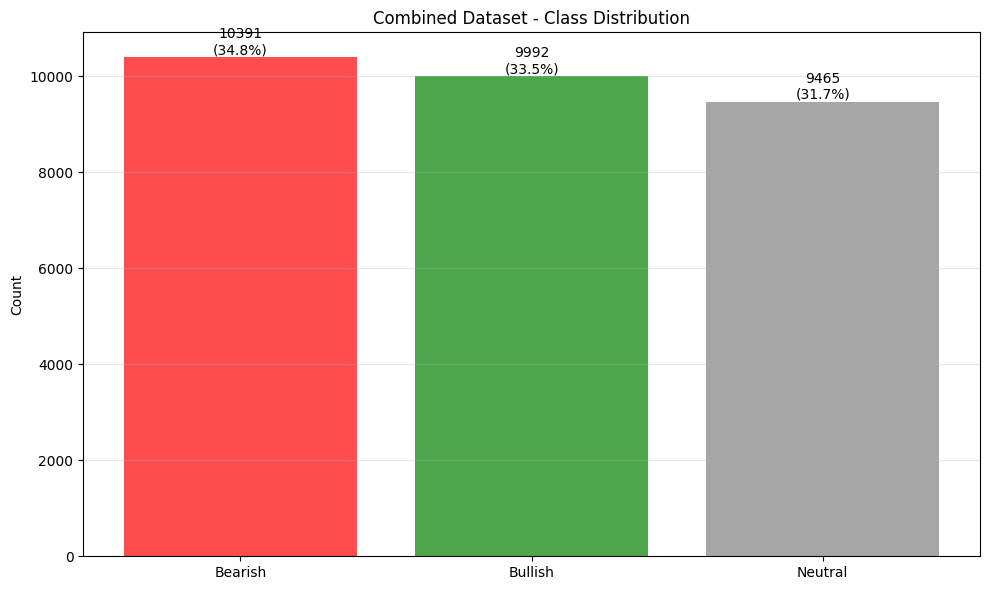


Total samples: 29,848


In [116]:
# Class distribution bar chart
fig, ax = plt.subplots(figsize=(10, 6))

class_names = ['Bearish', 'Bullish', 'Neutral']
class_counts = [np.sum(y_combined == i) for i in range(3)]
colors = ['red', 'green', 'gray']

bars = ax.bar(class_names, class_counts, color=colors, alpha=0.7)
ax.set_ylabel('Count')
ax.set_title('Combined Dataset - Class Distribution')
ax.grid(alpha=0.3, axis='y')

# Add count labels on bars
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({100*count/len(y_combined):.1f}%)',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nTotal samples: {len(y_combined):,}")